### Entrenamiento 3  conv + maxpool + dense + dropout + dense (99.10%)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 64)                18496     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

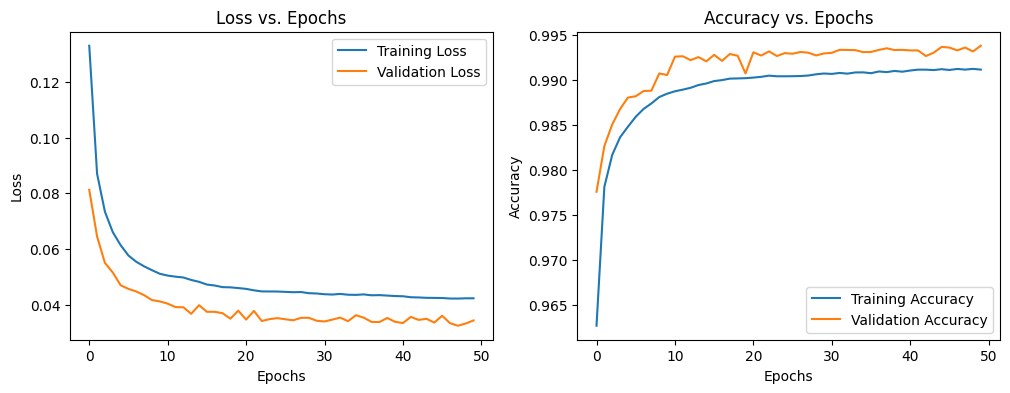

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('../dataset/data/sample_3M_cod.csv')

# Asignar la columna de etiquetas a AttackCod
AttackCod = df['AttackCod'].values

NIDS_features = ['L4_SRC_PORT','L4_DST_PORT', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
                'DURATION_IN', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES',
                'DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN']  # Mantengo la lista de características como estaba

X = df[NIDS_features]

# Escalamos solo las características (X) y no las etiquetas (y)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Dividir datos
X_train, X_temp, y_train, y_temp = train_test_split(X, AttackCod, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Definición del modelo
# Cambiar la forma de los datos para que sean compatibles con la CNN
# Asumiendo que X_train tiene una forma (n_samples, n_features)
# Lo cambiamos a (n_samples, n_features, 1) para que sea tratado como una imagen de 1D con múltiples canales
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definición del modelo CNN
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Adaptación de la métrica F1 para multiclase
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return K.mean(f1_val)

# Compilar modelo con las métricas adicionales
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', f1_metric])

# Resumen del modelo
model.summary()

# Entrenar modelo
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=150)99.01
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=200)#99.15

#loss, accuracy = model.evaluate(X_test, y_test)
#print(f"AccuracyTest: {accuracy*100:.2f}%")

# Post-procesamiento para obtener las clases
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Los gráficos proporcionados muestran el rendimiento de un modelo de aprendizaje automático durante su entrenamiento y validación a lo largo de varias épocas. Una época es una iteración completa sobre el conjunto completo de datos de entrenamiento.

En el gráfico de la izquierda, "Loss vs. Epochs", se muestra cómo la función de pérdida (loss) disminuye a medida que aumenta el número de épocas tanto para el conjunto de entrenamiento como para el de validación. La función de pérdida es una medida de cuán bien el modelo predice la salida deseada; un valor más bajo indica un mejor rendimiento. Aquí, la línea azul representa la pérdida de entrenamiento y la línea naranja la pérdida de validación. Ambas disminuyen, lo que indica que el modelo está aprendiendo y mejorando su predicción a medida que pasa por más épocas. Sin embargo, la pérdida de validación se estabiliza y parece comenzar a aplanarse hacia el final, lo que puede ser un indicio de que el modelo está comenzando a converger y que entrenamientos adicionales podrían no llevar a mejoras significativas.

En el gráfico de la derecha, "Accuracy vs. Epochs", la precisión (accuracy) del modelo aumenta con el número de épocas. La precisión es la proporción de predicciones correctas entre todas las predicciones realizadas. La línea azul indica la precisión del entrenamiento y la línea naranja la precisión de la validación. En ambos casos, la precisión mejora significativamente al principio y luego muestra un crecimiento más lento a medida que el número de épocas aumenta. La precisión de validación sigue de cerca a la de entrenamiento, lo que es una buena señal de que el modelo generaliza bien y no está sobreajustado (overfitting) a los datos de entrenamiento.

En general, la interpretación de estos gráficos sugiere que el modelo está aprendiendo efectivamente y que el entrenamiento está siendo productivo. No hay señales claras de sobreajuste, ya que la precisión y la pérdida de validación no empeoran con el tiempo, y la convergencia de ambos, precisión y pérdida, sugiere que el modelo podría estar cerca de su capacidad de aprendizaje óptima dado el actual régimen de entrenamiento y arquitectura del modelo.